In [3]:
pip install gym pygame gym[other]

zsh:1: no matches found: gym[other]
Note: you may need to restart the kernel to use updated packages.


In [4]:
git clone https://github.com/tensorflow/tensorflow.git
cd tensorflow
./configure

SyntaxError: invalid syntax (3930454489.py, line 1)

In [ ]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Hiperparametreler
num_episodes = 100
eps = 1.0
eps_decay = 0.999
eps_min = 0.01

# Epsilon değerine dayalı olarak bir eylem seçer
def choose_action(state, eps):
    if np.random.uniform(0, 1) < eps:
        return env.action_space.sample()
    else:
        q_values = model.predict(state)
        return np.argmax(q_values[0])

# Gözlem verilerini modele uygun hale getirir
def get_state(observation):
    return np.array(observation).reshape(1, -1)

# OpenAI Gym'de CartPole oyununu başlat
env = gym.make('CartPole-v1')

# Modeli tanımla
model = Sequential()
model.add(Dense(64, input_shape=(4,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse', optimizer=Adam(lr=0.001))

# Modeli eğit
for i in range(num_episodes):
    obs = env.reset()
    state = get_state(obs)
    done = False
    while not done:
        action = choose_action(state, eps)
        new_obs, reward, done, info = env.step(action)
        new_state = get_state(new_obs)
        target = model.predict(state)
        target[0][action] = reward + 0.95*np.max(model.predict(new_state)[0])
        model.fit(state, target, epochs=1, verbose=0)
        state = new_state
    eps = max(eps*eps_decay, eps_min)
    #print("Episode:", i+1, "Score:", info['score'])

# Modeli test et
obs = env.reset()
state = get_state(obs)
done = False
while not done:
    action = choose_action(state, eps_min)
    obs, reward, done, info = env.step(action)
    state = get_state(obs)
    env.render()


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.9/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


error: ignored

In [ ]:
!ls

sample_data


In [ ]:
import time
import gym
import gym_cap
import gym_cap.heuristic as policy
import numpy as np
import torch
import configparser

def change_ini_settings(file_path, section, key, new_value):
    config = configparser.ConfigParser()
    config.read(file_path)
    original_value = config.get(section, key)
    config.set(section, key, new_value)

    with open(file_path, 'w') as config_file:
        config.write(config_file)
    return original_value




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("cap-v0")


output_file = open("results_1000_new.txt", "a")  # Metin dosyasını yazmak için dosya açılır
num_match = 1000
setting_file = 'setting.ini'

red_list=['Roomba'] #['Defense','Random','Zeros']
blue_list=['Defense','Patrol','Spiral','Random','Zeros']
values_to_change = {
    'elements': {
        'NUM_RED': '6',
        'NUM_RED_UAV': '3'
    },
    'settings': {
        'STOCH_TRANSITIONS': 'False',
        'STOCH_ATTACK': 'True'
    },
    'control': {
        'RED_ADV_BIAS': '2'
    },
    'memory': {
        'TEAM_MEMORY': 'fog',
        'INDIV_MEMORY': 'fog'
    },
    'communication': {
        'COM_GROUND': 'True',
        'COM_DISTANCE': '2'
    }
}

for section, key_value_dict in values_to_change.items():
    for key, new_value in key_value_dict.items():
        original_value = change_ini_settings(setting_file, section, key, new_value)

        output_file.write("time: " + time.ctime(time.time()) + " ( "+ key + " "+ original_value +" => "+ new_value +" )  \n")
        for bl in blue_list:
            for rl in red_list:
                observation = env.reset(
                                    map_size=20,
                                    config_path=setting_file,
                                    policy_red=getattr(policy, rl)(),
                                    policy_blue=getattr(policy, bl)() #policy.Fighter() # Defense Random Fighter Zeros Roomba Patrol Spiral Policy blue_policy
                                )
                action = env.action_space.sample()
                rscore = []
                start_time = time.time()

                for n in range(num_match):
                    done = False
                    rewards = []
                    while not done:
                        observation, reward, done, info = env.step(action)
                        rewards.append(reward)
                    env.reset()
                    rscore.append(sum(rewards))
                    duration = time.time() - start_time
                    #print("Time: %.2f s, Score: %.2f" % (duration, rscore[-1]))

                average_time = duration / num_match
                average_score = sum(rscore) / num_match
                print("red: "+rl+" blue: "+ bl+ " Average Time: %.2f s, Average Score: %.2f" % (duration/num_match, sum(rscore)/num_match))
                output_file.write("red: " + rl + " blue: " + bl + " Average Time: %.2f s, Average Score: %.2f\n" % (average_time, average_score))
        output_file.write("bitiş time: " + time.ctime(time.time()) + "\n")
        change_ini_settings(setting_file, section, key, original_value)


output_file.close()
env.close()

UnregisteredEnv: No registered env with id: cap-v0

Test with PPO model

In [3]:
import gymnasium as gym
import gym_cap  # gym_cap environment
from stable_baselines3 import PPO, DQN, A2C
import matplotlib.pyplot as plt
import numpy as np
import gym_cap.heuristic as policy

""" from gym import spaces
class Board(spaces.Space):
    
    def __init__(self, _shape=None, dtype=np.uint8):
        assert dtype is not None, 'dtype must be explicitly provided. '
        self.dtype = np.dtype(dtype)

        if _shape is None:
            self.shape = (20, 20, NUM_CHANNEL)
        else:
            assert _shape[2] == NUM_CHANNEL
            self.shape = tuple(_shape)
        super(Board, self).__init__(self.shape, self.dtype)

    def __repr__(self):
        return "Board" + str(self.shape)

    def sample(self):
        map_obj = [NUM_BLUE, NUM_BLUE_UAV, NUM_RED, NUM_RED_UAV, NUM_GRAY]
        state, _, _ = gen_random_map('map',
                self.shape[0], rand_zones=False, map_obj=map_obj)
        return state"""


class CompatibleEnv(gym.Wrapper):
    def reset(self, **kwargs):
        # Ensure seed is not passed if not handled by the environment
        kwargs.pop('seed', None)

        # Reset and manage all returned values appropriately
        output = self.env.reset(**kwargs)
        if isinstance(output, tuple):
            # Only return the observation (assuming it's the first item)
            return output[0]
        return output  # Return directly if not a tuple
# Wrap your environment
enva = CompatibleEnv(gym.make('cap-v0'))
# Ortamı oluşturun
env = gym.make('cap-v0')
envx = gym.make('CartPole-v1')

# PPO modelini oluşturun
model = PPO("MlpPolicy", env, verbose=1)

# Eğitim adımları ve kazanma oranlarını kaydetmek için değişkenler
num_games = 50  # Toplam oyun sayısı
timesteps_per_game = 1000  # Her oyun için zaman adımı
win_rates = []
#model.learn(total_timesteps=timesteps_per_game)

# Modeli eğitin ve kazanma oranlarını kaydedin
obs = env.reset(
                    map_size=20,
                    #config_path='/demo/base_setting.ini',
                    policy_red=getattr(policy, 'Roomba')(),
                    policy_blue=getattr(policy, 'Zeros')() #policy.Fighter() # Defense Random Fighter Zeros Roomba Patrol Spiral Policy blue_policy
                )
for game in range(num_games):
    model.learn(total_timesteps=timesteps_per_game)
    rewards = []
    # Kazanma oranını hesaplayın
    
    wins = 0
    for _ in range(timesteps_per_game):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(int(action))
        rewards.append(reward)
        if 'win' in info and info['win']:
            wins += 1
        if done:
            obs = env.reset()
    
    obs = env.reset()
    win_rate = sum(rewards) / timesteps_per_game  #wins
    win_rates.append(win_rate)
    print(f"Game {game + 1}/{num_games}: Win Rate = {win_rate:.2f}")

# Modeli kaydedin
model.save("ppo_ctf_model")

# Kazanma oranı grafiğini oluşturun
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_games + 1), win_rates, marker='o', linestyle='-', color='b')
plt.title('Win Rate per Game')
plt.xlabel('Game Number')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()

# Ortamı kapatın
env.close()


/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
Traceback (most recent

TypeError: reset() got an unexpected keyword argument 'seed'

In [ ]:
import gymnasium as gym
import gym_cap
import gym_cap.heuristic as policy
# Gym environment 'CartPole-v1' ile bir ortam oluşturuyoruz
env = gym.make('cap-v0')

# Ortamı başlat
#observation = env.reset()

# Toplam adım sayısı
total_steps = 1000
observation = env.reset(
                    map_size=20,
                    #config_path='/demo/base_setting.ini',
                    policy_red=getattr(policy, 'Roomba')(),
                    policy_blue=getattr(policy, 'Roomba')() #policy.Fighter() # Defense Random Fighter Zeros Roomba Patrol Spiral Policy blue_policy
                )
action = env.action_space.sample()
# Simülasyonu çalıştır
for step in range(total_steps):
    # Ortamı render et (opsiyonel)
    #action = env.action_space.sample()
    rewards = []
    done = False
    while not done:
        observation, reward, done, info = env.step(int(action))
        rewards.append(reward)
    env.reset()
    
    # Rastgele bir eylem seç
    #action = env.action_space.sample()
    
    # Eylemi gerçekleştirin ve yeni durumu alın
    #observation, reward, done, info = env.step(action)
    
    # Eğer epizot tamamlandıysa ortamı resetle
    if done:
        observation = env.reset()

# Ortamı kapat
env.close()

/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/envs/registration.py:481: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/yakuponur/miniconda3/envs/asr/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning:

Yeni bir mantık

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 762  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
Model 0 Total rewards: 0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 775  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 4096 |
-----------------------------
Model 1 Total rewards: 0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 771  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 6144 |
-----------------------------
Model 2 Total rewards: 0
Using cpu dev

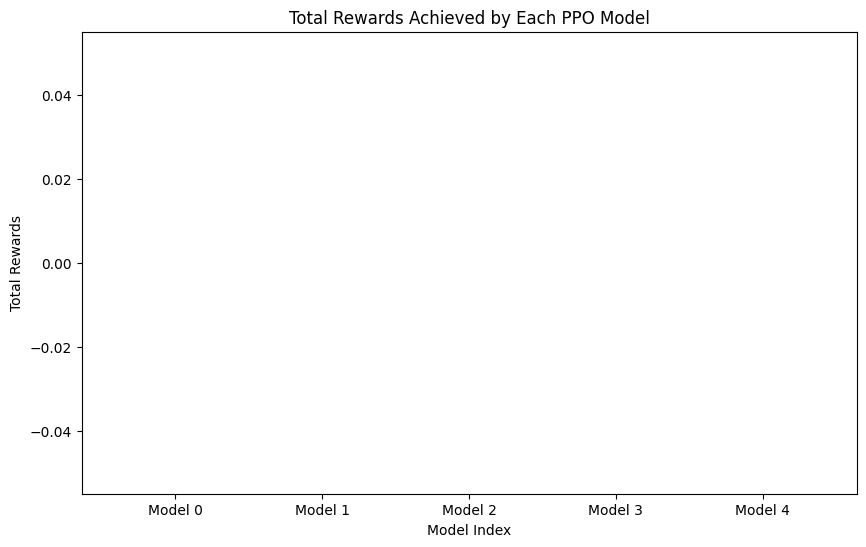

In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import PPO

# Custom environment class
class CaptureTheFlagEnv(gym.Env):
    def __init__(self):
        super(CaptureTheFlagEnv, self).__init__()
        self.action_space = spaces.MultiDiscrete([5, 5, 5, 5])
        self.observation_space = spaces.Dict({
            'team_1': spaces.Box(low=0, high=10, shape=(4, 2), dtype=np.float32),
            'team_2': spaces.Box(low=0, high=10, shape=(4, 2), dtype=np.float32),
            'flags': spaces.Box(low=0, high=10, shape=(2, 2), dtype=np.float32),
        })
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.team_1_pos = np.random.randint(0, 10, size=(4, 2))
        self.team_2_pos = np.random.randint(0, 10, size=(4, 2))
        self.flags_pos = np.random.randint(0, 10, size=(2, 2))
        return {
            'team_1': self.team_1_pos,
            'team_2': self.team_2_pos,
            'flags': self.flags_pos,
        }, {}

    def step(self, action):
        done = False
        reward = 0
        # Implement logic to update positions, check if flag is captured, calculate rewards, etc.

        # For demonstration, assume the episode ends after one step
        terminated = False  # Set to True if the episode has ended
        truncated = False   # Set to True if the episode was truncated (e.g., due to time limit)
        info = {}  # Additional info, can be left empty

        return {
            'team_1': self.team_1_pos,
            'team_2': self.team_2_pos,
            'flags': self.flags_pos,
        }, reward, terminated, truncated, info

    def render(self, mode='human'):
        pass

# Create environment
env = CaptureTheFlagEnv()

# Train and evaluate multiple PPO models
models = []
total_rewards_list = []
for i in range(5):
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048 * (i + 1))
    model.learn(total_timesteps=1000)
    models.append(model)
    
    # Evaluate each model
    obs, _ = env.reset()
    total_rewards = 0
    for _ in range(1000):
        action, _states = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        total_rewards += reward
        if terminated or truncated:
            break
    total_rewards_list.append(total_rewards)
    print(f"Model {i} Total rewards: {total_rewards}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(range(len(total_rewards_list)), total_rewards_list, color='skyblue')
plt.xlabel('Model Index')
plt.ylabel('Total Rewards')
plt.title('Total Rewards Achieved by Each PPO Model')
plt.xticks(range(len(total_rewards_list)), [f'Model {i}' for i in range(len(total_rewards_list))])
plt.show()
